# Experimental Results for Paper

In [1]:
import dp4gp_datasets
import dp4gp
import random
import numpy as np
import GPy
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

warning in stationary: failed to import cython module: falling back to numpy


## House prices


Skip this if you want, and load precomputed data from the csv file below:

In [4]:
if False:
    #region's boundaries
    #london_east = 530000
    #london_north = 180000
    #size = 50000

    #dp4gp_datasets.setup_postcodes('') #only needs calling once
    c = dp4gp_datasets.load_prices_and_postcode()

    #samp = (c['easting']>london_east-size) & (c['easting']<london_east+size) & (c['northing']>london_north-size) & (c['northing']<london_north+size)
    #c = c[samp]
    c = c.ix[random.sample(c.index, 10000)]

    #adds column of highest qualifications
    c = dp4gp_datasets.add_ons_column(c,'QS501EW')
    c.to_csv('price_dataset10k_wholeuk.csv')

Load precomputed dataset:

In [2]:
import pandas as pd
c = pd.read_csv('price_dataset10k_wholeuk.csv') #('price_dataset10k.csv')

In [3]:
c

,Unnamed: 0,postcode,easting,northing,Unnamed: 0.1,price,date,type,seconds,years,...,QS501EW_1,QS501EW_2,QS501EW_3,QS501EW_4,QS501EW_5,QS501EW_6,QS501EW_7,lat,lon,oa
0,0,S41 7DB,437496,372488,14297431,81000,2007-04-16 00:00,S,1176678000,2007,...,61,43,32,11,38,57,12,53.248091,-1.439525,E00098810
1,1,LE4 4AW,459424,308404,19639132,410000,2014-04-25 00:00,D,1398380400,2014,...,38,40,42,9,29,106,5,52.670433,-1.123136,E00130315
2,2,SE1 6BT,532015,179135,12456995,218000,2006-06-19 00:00,F,1150671600,2006,...,2,5,8,0,16,179,16,51.496050,-0.099246,E00167500
3,3,M13 0SA,386861,395307,19179482,97000,2014-08-15 00:00,T,1408057200,2014,...,130,38,29,1,33,75,58,53.454334,-2.199417,E00026516
4,4,RM7 9DA,550438,188249,774335,46000,1995-04-24 00:00,T,798678000,1995,...,42,32,42,11,42,63,21,51.573043,0.169399,E00011234
5,5,RG1 7UP,470894,173254,19396268,274000,2014-04-08 00:00,T,1396911600,2014,...,25,34,16,1,19,67,38,51.453794,-0.981085,E00082621
6,6,SW6 7AP,524812,177073,12522501,730000,2006-09-08 00:00,T,1157670000,2006,...,10,10,11,5,20,168,19,51.478810,-0.204156,E00009766
7,7,SW6 7AP,524812,177073,13685466,281000,2006-12-08 00:00,F,1165536000,2006,...,10,10,11,5,20,168,19,51.478810,-0.204156,E00009766
8,8,TR4 8TU,171880,47166,17754773,135500,2012-08-29 00:00,T,1346194800,2012,...,67,21,28,10,15,52,9,50.280271,-5.203264,E00095046
9,9,SA5 9AX,265262,197002,21188240,67250,2016-05-31 00:00,T,1464649200,2016,...,42,46,50,25,35,36,14,51.655610,-3.949180,W00004396


If you want to reduce the size of the dataset further;

In [6]:
c = c.ix[random.sample(c.index, 4000)]
#c = c[c['years']>2005]

Get it into a form we'll be able to predict over

In [7]:
#east, north, time, education -> price
training_inputs = np.vstack([c['easting'].values,c['northing'].values,c['seconds'].values,(c['QS501EW_6']/c['QS501EW_0']).values]).T
#training_inputs = training_inputs[:,0:3]
ys = c['price'].values

In [8]:
#squash data into £0k-£1M range
ys[ys>1e6] = 1e6
ys[ys<0] = 0
sens = 1e6-0

#rbf = GPy.kern.RBF(4,700e3,[15e3,15e3,50*31536000, 10.0],ARD=True)
rbf = GPy.kern.RBF(training_inputs.shape[1],1000e3,[15e3,15e3,50*31536000,5.0],ARD=True)
mod = GPy.models.GPRegression(training_inputs,ys[:,None],rbf)
mod.Gaussian_noise = 2000e3

dpgp = dp4gp.DPGP_cloaking(mod,sens,1.0,0.01)

#p = mod.plot(fixed_inputs=fixed_inputs,legend=False)
#xlim = p.axes.get_xlim()
#print xlim
#Xtest = 
#mu = dpgp.draw_prediction_samples(Xtest,20)
#dpgp.plot(fixed_inputs=[(1,180000),(2,np.max(c['seconds'])),(3,1)])
#plt.ylim([-2,2])

In [9]:
training_inputs.shape

(4000, 4)

 (1, 4000)
*
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


 /home/lionfish/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


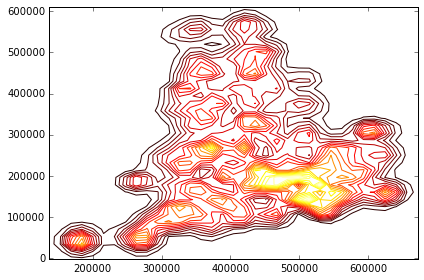

In [11]:
dpgp.plot(fixed_inputs=[(2,np.mean(training_inputs[:,2])), (3,np.mean(training_inputs[:,3]))],steps=12)

(array([ 368.,  433.,  518.,  544.,  477.,  480.,  246.,  279.,  321.,  334.]),
 array([  7.89177600e+08,   8.58807360e+08,   9.28437120e+08,
          9.98066880e+08,   1.06769664e+09,   1.13732640e+09,
          1.20695616e+09,   1.27658592e+09,   1.34621568e+09,
          1.41584544e+09,   1.48547520e+09]),
 <a list of 10 Patch objects>)

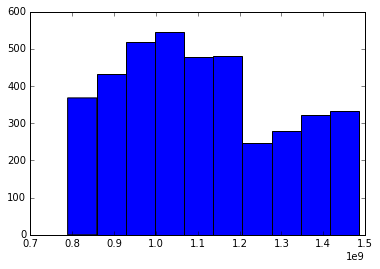

In [29]:
plt.hist(training_inputs[:,2])

1021


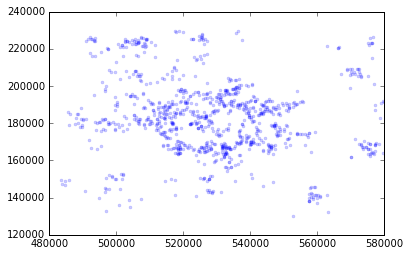

In [44]:
samp=[]
for i in [2,3]:
    #samp.append(abs(training_inputs[:,i]-np.mean(training_inputs[:,i]))<(np.std(training_inputs[:,i]*0.2)))
    samp.append(abs(training_inputs[:,i]-np.mean(training_inputs[:,i]))<(0.05*rbf.lengthscale[i]))
s = samp[0] & samp[1]
print np.sum(s) #~1000 are within 10% of a lengthscale
plt.plot(training_inputs[s,0],training_inputs[s,1],'.',alpha=0.2)

In [8]:
#N = 10
#fixed_inputs = [(1,180e3),(2,np.mean(training_inputs[:,2]))]
#Xtest, free_inputs = compute_Xtest(training_inputs, fixed_inputs, extent_lower={},steps=10)
#preds, mu, cov = dpgp.draw_prediction_samples(Xtest,N,Nattempts=1,Nits=100)